# Expectile-Regularized OT

## Expectile Regularization for Fast and Accurate Training of Neural Optimal Transport

The {class}`~ott.neural.methods.expectile_neural_dual.ExpectileNeuralDual` solves the dual OT problem where the objective is a sum 
of Kantorovich potential functions with additional expectile regularization {cite}`buzun:24`. The initialization arguments include:

- potential models that inherit from {class}`flax.linen.Module`,
- a cost function of type {class}`~ott.geometry.costs.CostFn`,
- `is_bidirectional` boolean parameter that indicates whether we train the OT mapping in both directions,
- and two regularization parameters, `expectile` and `expectile_loss_coef`.

The training procedure returns the {class}`~ott.neural.methods.expectile_neural_dual.ENOTPotentials` object that can be used to transport between input distributions or compute the corresponding OT distance between them.

In [2]:
import dataclasses
from collections.abc import Iterator, Mapping
from types import MappingProxyType
from typing import Any, Literal, Optional

import jax
import jax.numpy as jnp
import sklearn
import sklearn.datasets

import optax

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from ott import datasets
from ott.geometry import costs, pointcloud
from ott.neural.methods import expectile_neural_dual
from ott.neural.networks import potentials
from ott.tools import sinkhorn_divergence

## Evaluation on synthetic 2D datasets

In this section we show how ENOT finds optimal map between two measures constructed from {cite}`makkuva:20`. Here, we utilize {func}`~ott.datasets.create_gaussian_mixture_samplers` in order to get samples from source measure `square_five` and target measure `square_four`.
In our experiments, we use a custom implementation of {class}`~ott.neural.networks.potentials.MLP` for the potential models. Under the hood, the optimization is done with respect to the type of the cost function (e.g., {class}`~ott.geometry.costs.SqEuclidean` or {class}`~ott.geometry.costs.PNormP`).

In [3]:
num_samples_visualize = 512
(
    train_dataloaders,
    valid_dataloaders,
    input_dim,
) = datasets.create_gaussian_mixture_samplers(
    name_source="square_five",
    name_target="square_four",
    valid_batch_size=num_samples_visualize,
    train_batch_size=2048,
)

eval_data_source = next(valid_dataloaders.source_iter)
eval_data_target = next(valid_dataloaders.target_iter)

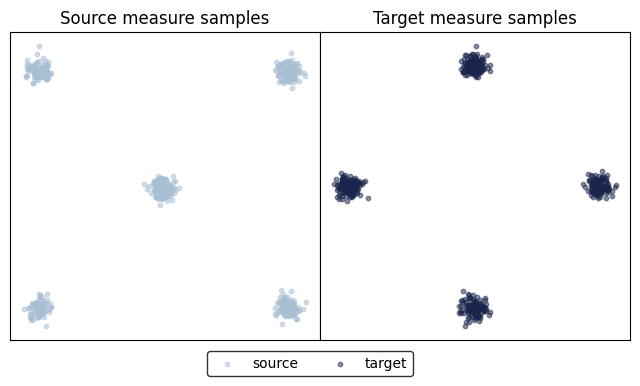

In [4]:
def plot_eval_samples(
    eval_data_source, eval_data_target, transported_samples=None
):
    fig, axs = plt.subplots(
        1, 2, figsize=(8, 4), gridspec_kw={"wspace": 0, "hspace": 0}
    )
    axs[0].scatter(
        eval_data_source[:, 0],
        eval_data_source[:, 1],
        color="#A7BED3",
        s=10,
        alpha=0.5,
        label="source",
    )
    axs[0].set_title("Source measure samples")
    axs[1].scatter(
        eval_data_target[:, 0],
        eval_data_target[:, 1],
        color="#1A254B",
        s=10,
        alpha=0.5,
        label="target",
    )
    axs[1].set_title("Target measure samples")

    if transported_samples is not None:
        axs[1].scatter(
            transported_samples[:, 0],
            transported_samples[:, 1],
            color="#F2545B",
            s=10,
            alpha=0.5,
            label="pushforward of source",
        )

    fig.legend(
        **{
            "ncol": (3 if transported_samples is not None else 2),
            "loc": "upper center",
            "bbox_to_anchor": (0.5, 0.1),
            "edgecolor": "k",
        }
    )

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    return fig, ax


fig, ax = plot_eval_samples(eval_data_source, eval_data_target)
display(fig)
plt.close(fig)

In [5]:
num_train_iters = 90_001


def training_callback(step, learned_potentials):
    if step % 2500 == 0:
        clear_output()
        print(f"Training iteration: {step}/{num_train_iters}")

        neural_dual_dist = learned_potentials.distance(
            eval_data_source, eval_data_target
        )
        print(
            f"Neural dual distance between source and target data: {neural_dual_dist:.2f}"
        )

        fig, ax = learned_potentials.plot_ot_map(
            eval_data_source,
            eval_data_target,
            forward=True,
        )
        display(fig)
        plt.close(fig)

        fig, ax = learned_potentials.plot_ot_map(
            eval_data_source,
            eval_data_target,
            forward=False,
        )
        display(fig)
        plt.close(fig)

## Training

Here, by setting `is_bidirectional=True` in {class}`~ott.neural.methods.expectile_neural_dual.ExpectileNeuralDual`, we compute OT in a back-and-forth fashion. The main hyperparameters to look at are `expectile` and `expectile_loss_coef`, denoted in {cite}`buzun:24` as $\tau$ and $\lambda$, respectively.

Training iteration: 90000/90001
Neural dual distance between source and target data: 21.30


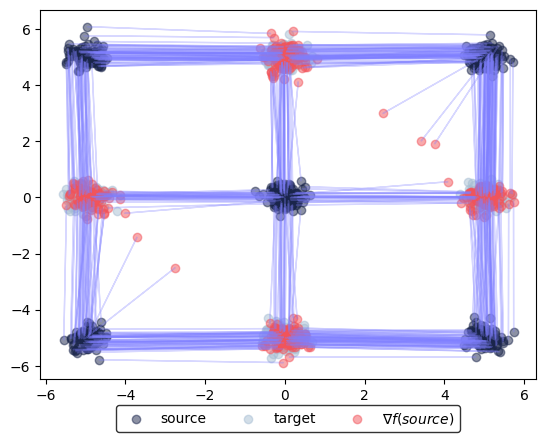

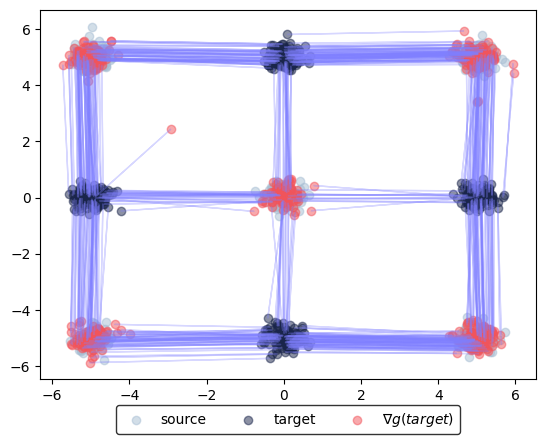

In [5]:
neural_f = potentials.MLP(dim_hidden=[128, 128, 128, 128, 1], act_fn=jax.nn.elu)
neural_g = potentials.MLP(dim_hidden=[128, 128, 128, 128, 1], act_fn=jax.nn.elu)

lr_schedule_f = optax.cosine_decay_schedule(
    init_value=5e-4, decay_steps=num_train_iters, alpha=1e-2
)

lr_schedule_g = optax.cosine_decay_schedule(
    init_value=5e-4, decay_steps=num_train_iters, alpha=1e-2
)
optimizer_f = optax.adam(learning_rate=lr_schedule_f, b1=0.9, b2=0.999)
optimizer_g = optax.adam(learning_rate=lr_schedule_g, b1=0.9, b2=0.999)

neural_dual_solver = expectile_neural_dual.ExpectileNeuralDual(
    input_dim,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    cost_fn=costs.SqEuclidean(),
    num_train_iters=num_train_iters,
    expectile=0.98,
    expectile_loss_coef=0.25,
    rng=jax.random.PRNGKey(5),
    is_bidirectional=True,
    use_dot_product=False,
)
learned_potentials = neural_dual_solver(
    *train_dataloaders,
    *valid_dataloaders,
    callback=training_callback,
)

## Evaluation

In [6]:
@jax.jit
def sinkhorn_loss(
    x: jnp.ndarray, y: jnp.ndarray, epsilon: float = 0.001
) -> float:
    """Computes transport between (x, a) and (y, b) via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)

    sdiv, _ = sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud, x, y, epsilon=epsilon, a=a, b=b
    )
    return sdiv

In [7]:
pred_target = learned_potentials.transport(eval_data_source)
print(
    f"Sinkhorn distance between target predictions and data samples: {sinkhorn_loss(pred_target, eval_data_target):.2f}"
)

pred_source = learned_potentials.transport(eval_data_target, forward=False)
print(
    f"Sinkhorn distance between source predictions and data samples: {sinkhorn_loss(pred_source, eval_data_source):.2f}"
)

neural_dual_dist = learned_potentials.distance(
    eval_data_source, eval_data_target
)
print(
    f"Neural dual distance between source and target data: {neural_dual_dist:.2f}"
)

sinkhorn_dist = sinkhorn_loss(eval_data_source, eval_data_target)
print(f"Sinkhorn distance between source and target data: {sinkhorn_dist:.2f}")

Sinkhorn distance between target predictions and data samples: 0.11
Sinkhorn distance between source predictions and data samples: 0.11
Neural dual distance between source and target data: 21.30
Sinkhorn distance between source and target data: 21.24


## MAFMoons & Rings synthetic datasets

Below, we show how ENOT handles more challenging tasks. For this case, we implement the `MAFMoonSampler` and `RingSampler` data samplers.

In [7]:
@dataclasses.dataclass
class MAFMoonSampler:
    size: int

    def __iter__(self):
        rng = jax.random.PRNGKey(0)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield self._sample(sample_key, self.size)

    def _sample(self, key, batch_size):
        x = jax.random.normal(key, shape=[batch_size, 2])
        x = x.at[:, 0].add(x[:, 1] ** 2)
        x = x.at[:, 0].mul(0.5)
        x = x.at[:, 0].add(-5)
        return x


@dataclasses.dataclass
class RingSampler:
    size: int

    def __iter__(self):
        rng = jax.random.PRNGKey(0)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield self._sample(sample_key, self.size)

    def _sample(self, key, batch_size):
        n_samples4 = n_samples3 = n_samples2 = batch_size // 4
        n_samples1 = batch_size - n_samples4 - n_samples3 - n_samples2

        linspace4 = jnp.linspace(0, 2 * jnp.pi, n_samples4, endpoint=False)
        linspace3 = jnp.linspace(0, 2 * jnp.pi, n_samples3, endpoint=False)
        linspace2 = jnp.linspace(0, 2 * jnp.pi, n_samples2, endpoint=False)
        linspace1 = jnp.linspace(0, 2 * jnp.pi, n_samples1, endpoint=False)

        circ4_x = jnp.cos(linspace4) * 1.2
        circ4_y = jnp.sin(linspace4) * 1.2
        circ3_x = jnp.cos(linspace4) * 0.9
        circ3_y = jnp.sin(linspace3) * 0.9
        circ2_x = jnp.cos(linspace2) * 0.55
        circ2_y = jnp.sin(linspace2) * 0.55
        circ1_x = jnp.cos(linspace1) * 0.25
        circ1_y = jnp.sin(linspace1) * 0.25

        X = (
            jnp.vstack(
                [
                    jnp.hstack([circ4_x, circ3_x, circ2_x, circ1_x]),
                    jnp.hstack([circ4_y, circ3_y, circ2_y, circ1_y]),
                ]
            ).T
            * 3.0
        )
        X = sklearn.utils.shuffle(X)

        # Add noise
        X = X + jax.random.normal(key, shape=X.shape) * 0.08

        return X.astype("float32")

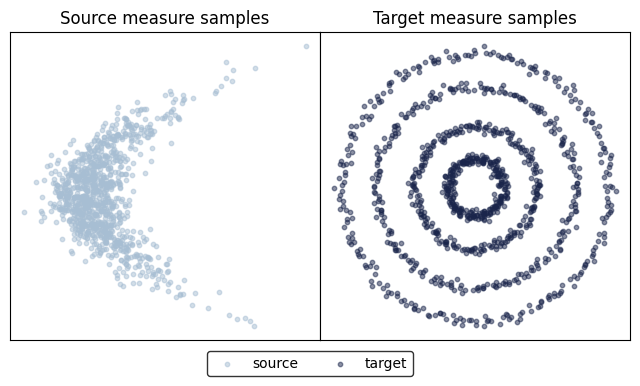

In [8]:
train_loader = datasets.Dataset(
    source_iter=iter(MAFMoonSampler(size=1024)),
    target_iter=iter(RingSampler(size=1024)),
)
valid_loader = train_loader

moon_samples = next(train_loader.source_iter)
ring_samples = next(train_loader.target_iter)

fig, ax = plot_eval_samples(moon_samples, ring_samples)
display(fig)
plt.close(fig)

In [27]:
eval_data_source = next(valid_loader.source_iter)
eval_data_target = next(valid_loader.target_iter)

neural_f = potentials.MLP(dim_hidden=[128, 128, 128, 128, 1], act_fn=jax.nn.elu)
neural_g = potentials.MLP(dim_hidden=[128, 128, 128, 128, 1], act_fn=jax.nn.elu)

num_train_iters = 90_001
lr_schedule_f = optax.cosine_decay_schedule(
    init_value=5e-4, decay_steps=num_train_iters, alpha=1e-3
)

lr_schedule_g = optax.cosine_decay_schedule(
    init_value=5e-4, decay_steps=num_train_iters, alpha=1e-3
)
optimizer_f = optax.adam(learning_rate=lr_schedule_f, b1=0.9, b2=0.999)
optimizer_g = optax.adam(learning_rate=lr_schedule_g, b1=0.9, b2=0.999)

neural_dual_solver = expectile_neural_dual.ExpectileNeuralDual(
    2,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    cost_fn=costs.SqEuclidean(),
    num_train_iters=num_train_iters,
    expectile=0.99,
    expectile_loss_coef=0.3,
    rng=jax.random.PRNGKey(4),
    is_bidirectional=True,
)
learned_potentials = neural_dual_solver(*train_loader, *valid_loader)

  0%|          | 0/90001 [00:00<?, ?it/s]

Evaluate the `learned_potentials`.

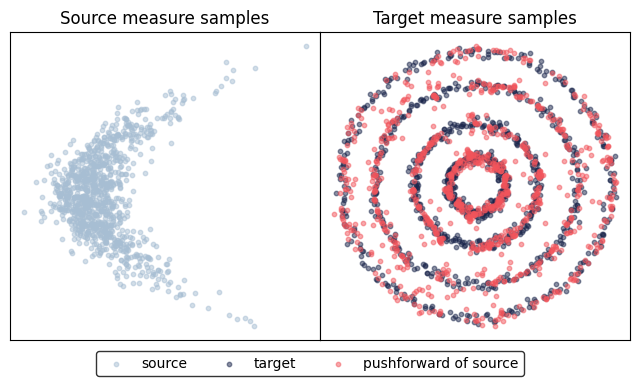

In [53]:
fig, ax = plot_eval_samples(
    moon_samples, ring_samples, learned_potentials.transport(moon_samples)
)
display(fig)
plt.close(fig)

## Different costs on 2D data

Next, we show how ENOT performs when varying the underlying cost function $c(x, y)$ on synthetic 2D datasets `HalfMoon` and `S_curve`.

In [11]:
@dataclasses.dataclass
class SklearnDistribution:
    name: Literal["moon", "s_curve"]
    theta_rotation: float = 0.0
    mean: Optional[jnp.ndarray] = None
    noise: float = 0.01
    scale: float = 1.0
    batch_size: int = 1024
    rng: Optional[jax.Array] = None

    def __iter__(self) -> Iterator[jnp.ndarray]:
        return self._create_sample_generators()

    def _create_sample_generators(self) -> Iterator[jnp.ndarray]:
        rng = jax.random.PRNGKey(0) if self.rng is None else self.rng
        rotation = jnp.array(
            [
                [jnp.cos(self.theta_rotation), -jnp.sin(self.theta_rotation)],
                [jnp.sin(self.theta_rotation), jnp.cos(self.theta_rotation)],
            ]
        )
        while True:
            rng, _ = jax.random.split(rng)
            seed = jax.random.randint(rng, [], minval=0, maxval=1e5).item()
            if self.name == "moon":
                samples, _ = sklearn.datasets.make_moons(
                    n_samples=(self.batch_size, 0),
                    random_state=seed,
                    noise=self.noise,
                )
            elif self.name == "s_curve":
                x, _ = sklearn.datasets.make_s_curve(
                    n_samples=self.batch_size,
                    random_state=seed,
                    noise=self.noise,
                )
                samples = x[:, [2, 0]]
            else:
                raise NotImplementedError(
                    f"SklearnDistribution `{self.name}` not implemented."
                )

            samples = jnp.asarray(samples, dtype=jnp.float32)
            samples = jnp.squeeze(jnp.matmul(rotation[None, :], samples.T).T)
            mean = jnp.zeros(2) if self.mean is None else self.mean
            samples = mean + self.scale * samples
            yield samples


def create_samplers(
    source_kwargs: Mapping[str, Any] = MappingProxyType({}),
    target_kwargs: Mapping[str, Any] = MappingProxyType({}),
    train_batch_size: int = 256,
    valid_batch_size: int = 256,
    rng: Optional[jax.Array] = None,
):
    rng = jax.random.PRNGKey(0) if rng is None else rng
    rng1, rng2, rng3, rng4 = jax.random.split(rng, 4)
    train_dataset = datasets.Dataset(
        source_iter=iter(
            SklearnDistribution(
                rng=rng1, batch_size=train_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                rng=rng2, batch_size=train_batch_size, **target_kwargs
            )
        ),
    )
    valid_dataset = datasets.Dataset(
        source_iter=iter(
            SklearnDistribution(
                rng=rng3, batch_size=valid_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                rng=rng4, batch_size=valid_batch_size, **target_kwargs
            )
        ),
    )
    dim_data = 2
    return train_dataset, valid_dataset, dim_data

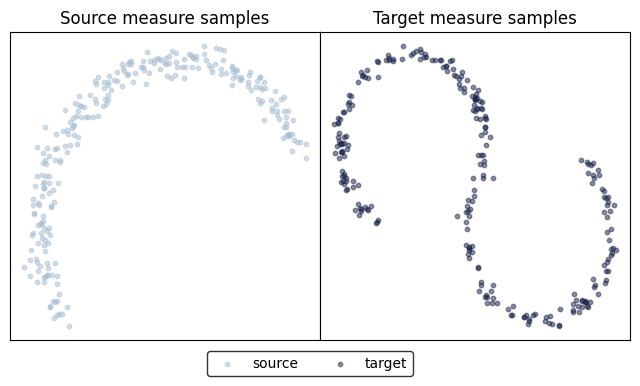

In [12]:
train_dataset, valid_dataset, dim_data = create_samplers(
    source_kwargs={
        "name": "moon",
        "theta_rotation": jnp.pi / 6,
        "mean": jnp.array([0.0, -0.5]),
        "noise": 0.05,
    },
    target_kwargs={
        "name": "s_curve",
        "scale": 0.6,
        "mean": jnp.array([0.5, -2.0]),
        "theta_rotation": -jnp.pi / 6,
        "noise": 0.05,
    },
)

train_source = next(train_dataset.source_iter)
train_target = next(train_dataset.target_iter)
fig, ax = plot_eval_samples(train_source, train_target)
display(fig)
plt.close(fig)

### Euclidean cost

Training iteration: 25000/25001
Neural dual distance between source and target data: 2.28


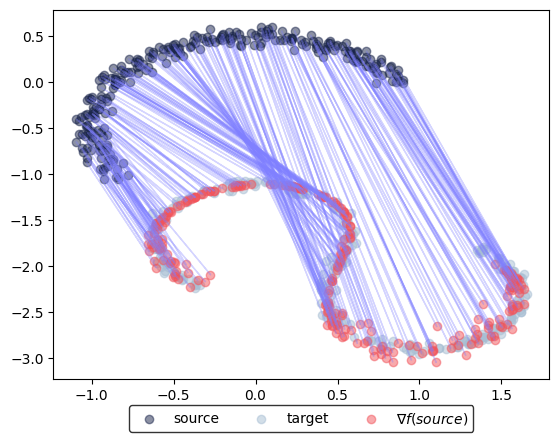

In [6]:
neural_f = potentials.MLP(dim_hidden=[64, 64, 64, 2], act_fn=jax.nn.gelu)
neural_g = potentials.MLP(dim_hidden=[64, 64, 64, 1], act_fn=jax.nn.gelu)

num_train_iters = 25_001

lr_schedule_f = optax.cosine_decay_schedule(
    init_value=3e-4, decay_steps=num_train_iters, alpha=1e-4
)

lr_schedule_g = optax.cosine_decay_schedule(
    init_value=3e-4, decay_steps=num_train_iters, alpha=1e-4
)
optimizer_f = optax.adam(learning_rate=lr_schedule_f, b1=0.9, b2=0.999)
optimizer_g = optax.adam(learning_rate=lr_schedule_g, b1=0.9, b2=0.999)


neural_dual_solver = expectile_neural_dual.ExpectileNeuralDual(
    2,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=num_train_iters,
    expectile=0.99,
    expectile_loss_coef=1,
    cost_fn=costs.Euclidean(),
    rng=jax.random.PRNGKey(42),
    is_bidirectional=False,
)

sample_data_source = next(train_dataset.source_iter)
sample_data_target = next(train_dataset.target_iter)


def training_callback(step, learned_potentials):
    if step % 5_000 == 0:
        clear_output()
        print(f"Training iteration: {step}/{num_train_iters}")

        neural_dual_dist = learned_potentials.distance(
            sample_data_source, sample_data_target
        )
        print(
            f"Neural dual distance between source and target data: {neural_dual_dist:.2f}"
        )

        fig, ax = learned_potentials.plot_ot_map(
            sample_data_source,
            sample_data_target,
            forward=True,
        )
        display(fig)
        plt.close(fig)


learned_potentials = neural_dual_solver(
    *train_dataset, *valid_dataset, callback=training_callback
)

### Squared-Euclidean cost

We change the cost to the {class}`~ott.geometry.costs.SqEuclidean` and visualize results:

Training iteration: 25000/25001
Neural dual distance between source and target data: 4.78


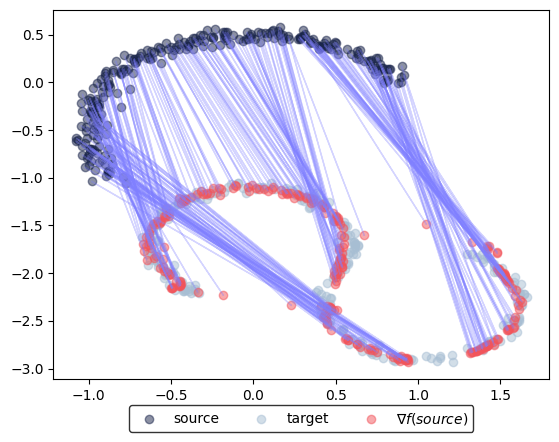

In [46]:
neural_dual_solver = expectile_neural_dual.ExpectileNeuralDual(
    2,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=num_train_iters,
    expectile=0.99,
    expectile_loss_coef=1,
    cost_fn=costs.SqEuclidean(),
    rng=jax.random.PRNGKey(42),
    is_bidirectional=False,
)

sample_data_source = next(train_dataset.source_iter)
sample_data_target = next(train_dataset.target_iter)

learned_potentials = neural_dual_solver(
    *train_dataset, *valid_dataset, callback=training_callback
)

### `PNormP` cost

Finally, we change the cost to the {class}`~ott.geometry.costs.PNormP` with $p=1.5$:

Training iteration: 25000/25001
Neural dual distance between source and target data: 2.57


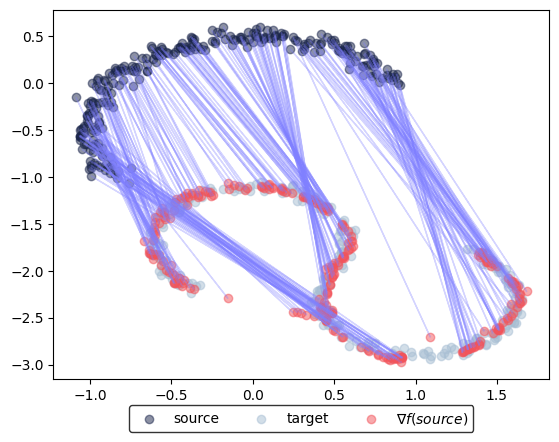

In [48]:
neural_dual_solver = expectile_neural_dual.ExpectileNeuralDual(
    2,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=num_train_iters,
    expectile=0.99,
    expectile_loss_coef=1,
    cost_fn=costs.PNormP(1.5),
    rng=jax.random.PRNGKey(42),
    is_bidirectional=False,
)

sample_data_source = next(train_dataset.source_iter)
sample_data_target = next(train_dataset.target_iter)

learned_potentials = neural_dual_solver(
    *train_dataset, *valid_dataset, callback=training_callback
)